### IMPORT libraries 

In [86]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset
from scipy.sparse.linalg import svds
    
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

### Load MOVIE LENS Dataset  (movie and rating) and Merge it 

In [41]:
movie_df=pd.read_csv("movie1.csv")
rating_df=pd.read_csv("rating.csv")

In [42]:
movie_df.count()

movieId    8999
title      8999
genres     8999
dtype: int64

In [43]:
rating_df.count()

userId       783359
movieId      783359
rating       783359
timestamp    783359
dtype: int64

<h1><b>Checking for NaN</b></h1>

In [44]:
print("Number of NaN values = "+str(movie_df.isnull().sum()))

Number of NaN values = movieId    0
title      0
genres     0
dtype: int64


In [45]:
print("Number of NaN values = "+str(rating_df.isnull().sum()))

Number of NaN values = userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [46]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [47]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,02/04/2005 23:53
1,1,29,3.5,02/04/2005 23:31
2,1,32,3.5,02/04/2005 23:33
3,1,47,3.5,02/04/2005 23:32
4,1,50,3.5,02/04/2005 23:29


### Removing Duplicates

In [48]:
duplicates = rating_df.duplicated(["userId","movieId", "rating"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


### Basic Statistics

In [49]:
print("Total Data:")
print("Total number of movie ratings = "+str(rating_df.shape[0]))
print("Number of unique users = "+str(len(np.unique(rating_df["userId"]))))
print("Number of unique movies = "+str(len(np.unique(rating_df["movieId"]))))

Total Data:
Total number of movie ratings = 783359
Number of unique users = 5216
Number of unique movies = 13563


### MERGE both movie and rating dataset with key as movieId

In [50]:
df = pd.merge(rating_df,movie_df,on='movieId').dropna()
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,02/04/2005 23:53,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,25/12/1996 15:26,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,27/11/1996 8:19,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,23/06/1996 20:36,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,28/10/1996 13:29,Jumanji (1995),Adventure|Children|Fantasy


In [51]:
df.count()  #695877

userId       695877
movieId      695877
rating       695877
timestamp    695877
title        695877
genres       695877
dtype: int64

### create data frame DF for find avg rating 

In [52]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marquise of O, The (Marquise von O..., Die) (1976)    5.0
Killing of Sister George, The (1968)                  5.0
Burnt Money (Plata Quemada) (2000)                    5.0
Swann in Love (Un amour de Swann) (1984)              5.0
Men, The (1950)                                       5.0
Name: rating, dtype: float64

### number of rating  based sorting

In [53]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Pulp Fiction (1994)                 2584
Forrest Gump (1994)                 2568
Silence of the Lambs, The (1991)    2386
Shawshank Redemption, The (1994)    2373
Jurassic Park (1993)                2301
Name: rating, dtype: int64

### create new dataframe name as ratings

In [54]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Round Midnight (1986),3.785714,7
'Til There Was You (1997),2.790323,31
"'burbs, The (1989)",3.031008,129
'night Mother (1986),3.222222,9
*batteries not included (1987),3.289474,76


## Data Analysis

Total range of data set (i.e from minimum value to maximum value) is divided into 8 to 15 equal parts. These equal parts are known as bins 

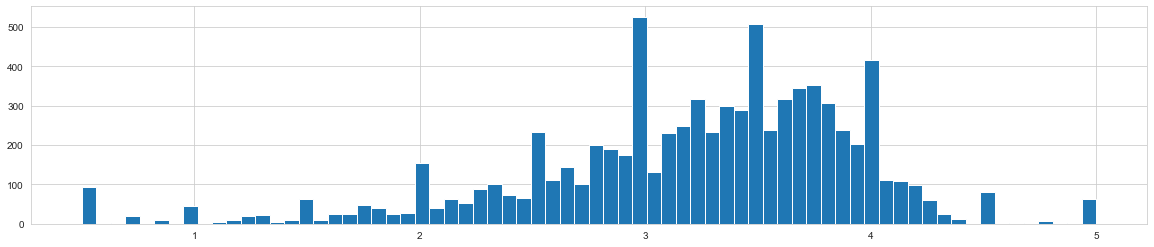

In [55]:
plt.figure(figsize=(20,4)) #width 20inches and height 4inches
ratings['rating'].hist(bins=70)  

it is  gaussian normal distribution.PDF probability density function satisfy this

In [56]:
def changingLabels(number):
    return str(number/10**6) + "M"

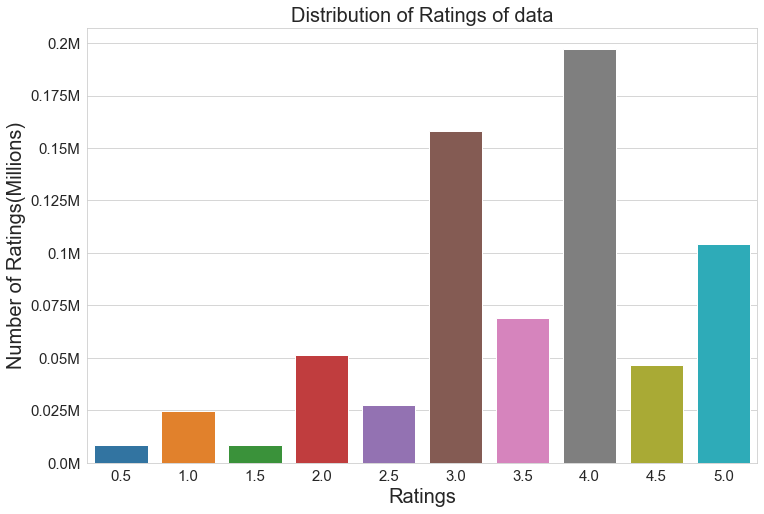

In [57]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings of data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

problem here is that to_datetime silently failed so the dtype remained as str/object, if you set param errors='coerce' then if the conversion fails for any particular string then those rows are set to NaT.

In [74]:
df['Date'] = pd.to_datetime(df['timestamp'], errors='coerce')
#df["DayOfWeek"] = df.Date.dt.weekday_name
df['DayOfWeek'] = df['Date'].dt.day_name()

In [75]:
df.tail()

,userId,movieId,rating,timestamp,title,genres,Date,Weekday,DayOfWeek
695872,5148,26339,3.0,02/01/2010 6:59,Dolemite (1975),Action|Comedy|Crime|Mystery|Thriller,2010-02-01 06:59:00,Monday,Monday
695873,5150,1528,3.0,16/05/1997 10:07,Intimate Relations (1996),Comedy,1997-05-16 10:07:00,Friday,Friday
695874,5177,8545,2.5,02/07/2004 23:18,Plain Dirty (a.k.a. Briar Patch) (2003),Drama|Romance,2004-02-07 23:18:00,Saturday,Saturday
695875,5190,3333,5.0,24/04/2000 16:45,"Killing of Sister George, The (1968)",Drama,2000-04-24 16:45:00,Monday,Monday
695876,5192,6018,4.5,31/01/2015 11:28,Kira's Reason: A Love Story (En Kærlighedshist...,Drama,2015-01-31 11:28:00,Saturday,Saturday


### Number of Ratings per month

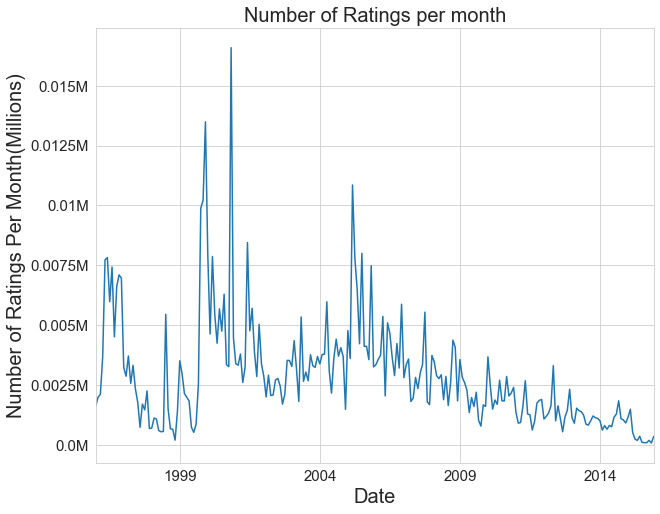

In [62]:
plt.figure(figsize = (10,8))
ax = df.resample("M", on = "Date")["rating"].count().plot()
#this above resample() function is a sort of group-by operation.Resample() function can work with dates. It can take months,
#days and years values independently. Here, in parameter we have given "M" which means it will group all the rows Monthly using 
#"Date" which is already present in the DataFrame. Now after grouping the rows month wise, we have just counted the ratings 
#which are grouped by months and plotted them. So, below plot shows that how many ratings are there per month. 
#In resample(), we can also give "6M" for grouping the rows every 6-Monthly, we can also give "Y" for grouping
#the rows yearly, we can also give "D" for grouping the rows by day.
#Resample() is a function which is designed to work with time and dates.
#This "df.resample("M", on = "Date")["Ratings"].count()" returns a pandas series where keys are Dates and values are 
#counts of ratings grouped by months.You can even check it and print it. Then we are plotting it, where it automatically takes
#Dates--which are keys on--x-axis and counts--which are values on--y-axis.
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

### Analysis of Ratings given by user

In [63]:
no_of_rated_movies_per_user = df.groupby(by = "userId")["rating"].count().sort_values(ascending = False)

In [64]:
no_of_rated_movies_per_user.head()

userId
903     2608
2261    2380
4358    2244
3318    2186
156     2179
Name: rating, dtype: int64

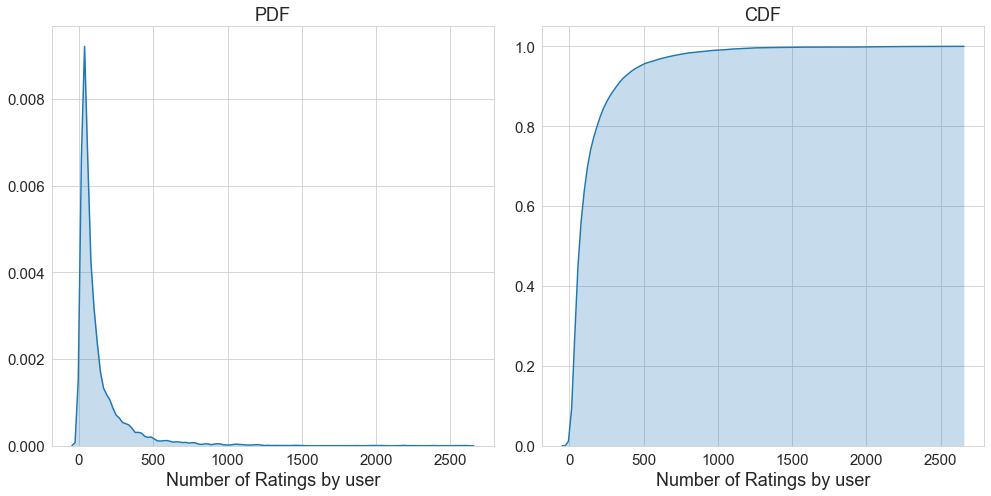

In [65]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

* PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [66]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    5216.000000
mean      133.412002
std       195.187249
min         1.000000
25%        33.000000
50%        64.000000
75%       148.000000
max      2608.000000
Name: rating, dtype: float64

In [67]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

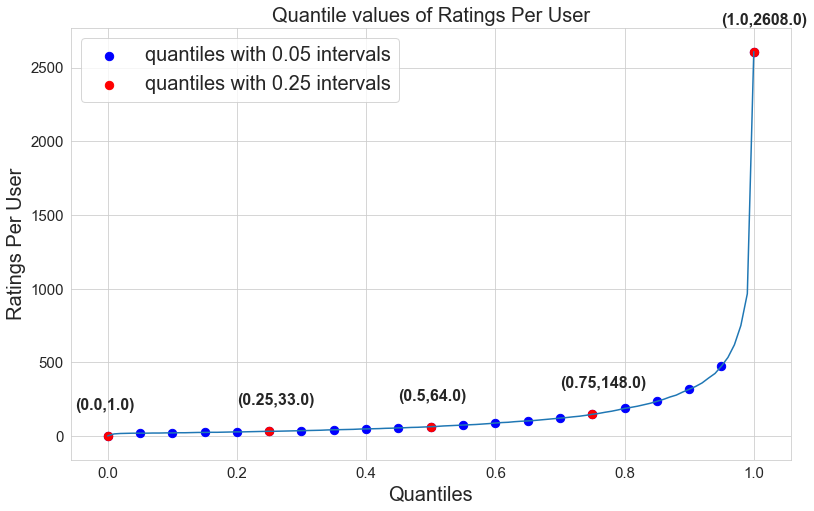

In [68]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

In [69]:
quantiles[::5]

0.00       1.00
0.05      20.00
0.10      22.00
0.15      25.00
0.20      29.00
0.25      33.00
0.30      37.00
0.35      43.00
0.40      49.00
0.45      56.00
0.50      64.00
0.55      75.00
0.60      89.00
0.65     103.00
0.70     122.00
0.75     148.00
0.80     188.00
0.85     235.75
0.90     317.50
0.95     475.25
1.00    2608.00
Name: rating, dtype: float64

In [70]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 3794
Total number of ratings above 75th percentile = 1422


### Analysis of Ratings Per Movie

In [71]:
no_of_ratings_per_movie = df.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)

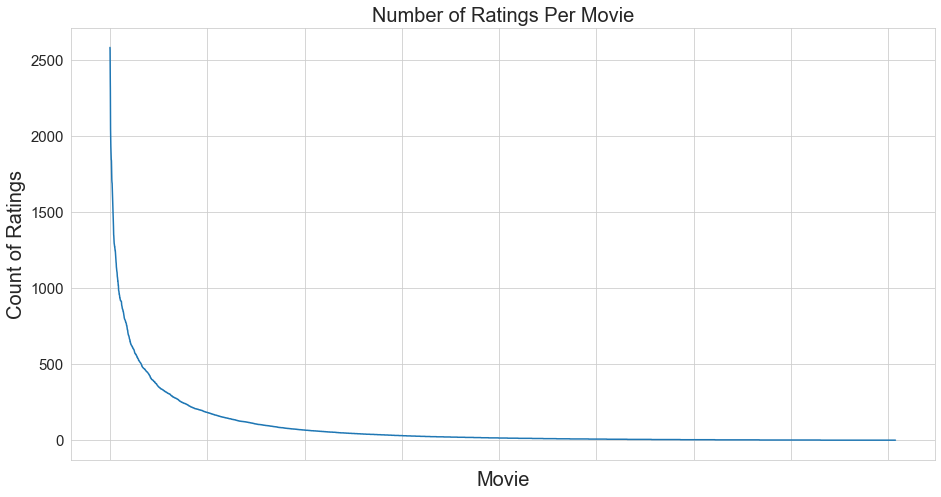

In [72]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

### Analysis of Movie Ratings on Day of Week

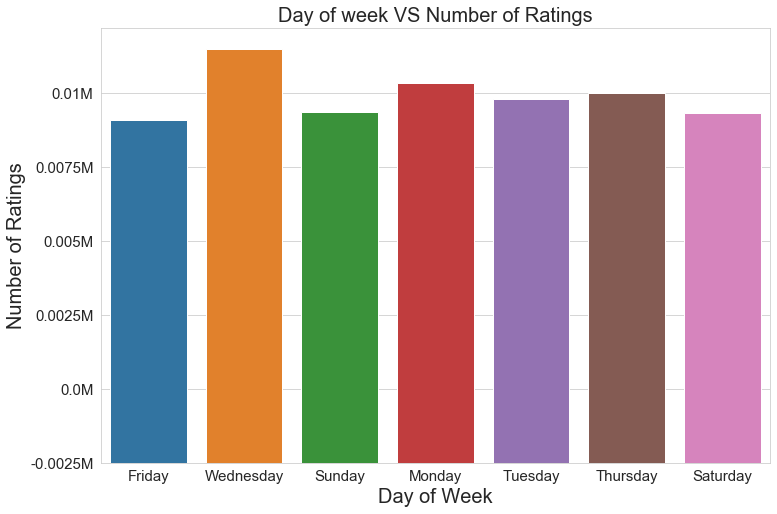

In [76]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = df)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

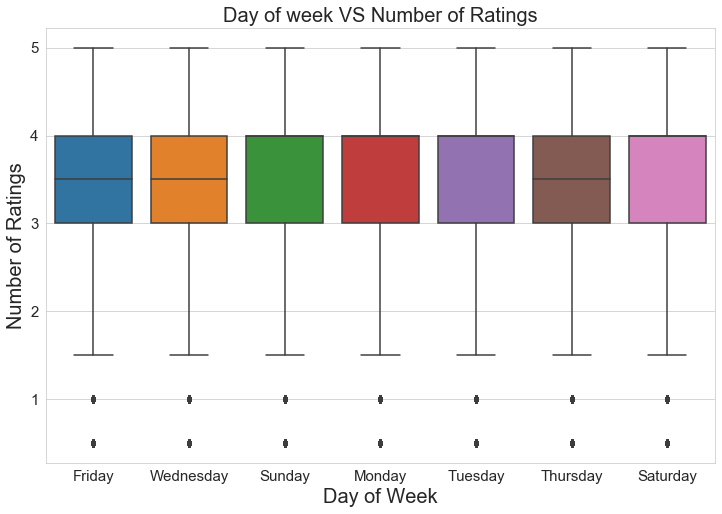

In [77]:
fig = plt.figure(figsize = (12, 8))
axes = sns.boxplot(x = "DayOfWeek", y = "rating", data = df)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)
plt.show()

In [78]:
average_ratings_dayofweek = df.groupby(by = "DayOfWeek")["rating"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
DayOfWeek
Friday       3.514822
Monday       3.537949
Saturday     3.533855
Sunday       3.524773
Thursday     3.493626
Tuesday      3.545351
Wednesday    3.492801
Name: rating, dtype: float64


In [81]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Pulp Fiction (1994),4.150929,2584
Forrest Gump (1994),4.058606,2568
"Silence of the Lambs, The (1991)",4.178332,2386
"Shawshank Redemption, The (1994)",4.473662,2373
Jurassic Park (1993),3.679270,2301
Star Wars: Episode IV - A New Hope (1977),4.177010,2127
Braveheart (1995),4.046188,2046
Terminator 2: Judgment Day (1991),3.943885,1987
"Matrix, The (1999)",4.169878,1972


### Matrix Factorization

In [79]:
MF= df.pivot_table(index='userId',columns='title',values='rating')
MF.head()

title,'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),*batteries not included (1987),"...All the Marbles (California Dolls, The) (1981)",...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),...,Zoolander (2001),Zoot Suit (1981),Zorba the Greek (Alexis Zorbas) (1964),"Zorro, the Gay Blade (1981)",Zulu (1964),Zus & Zo (2001),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
#Fill missing values with 0’s
MF.fillna(0,inplace=True)
MF

title,'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),*batteries not included (1987),"...All the Marbles (California Dolls, The) (1981)",...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),...,Zoolander (2001),Zoot Suit (1981),Zorba the Greek (Alexis Zorbas) (1964),"Zorro, the Gay Blade (1981)",Zulu (1964),Zus & Zo (2001),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
#Normalize the data by converting into numpy array first

User_mean=np.mean(MF,axis=1)
Matrix_normed=MF-User_mean.values.reshape(-1,1)

In [84]:
Matrix_normed

title,'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),*batteries not included (1987),"...All the Marbles (California Dolls, The) (1981)",...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),...,Zoolander (2001),Zoot Suit (1981),Zorba the Greek (Alexis Zorbas) (1964),"Zorro, the Gay Blade (1981)",Zulu (1964),Zus & Zo (2001),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,...,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619,-0.080619
2,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,...,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217,-0.030217
3,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,...,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480,-0.095480
4,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,...,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384,-0.012384
5,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,...,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923,-0.034923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,...,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898,-0.010898
5213,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,...,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632,-0.012632
5214,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,...,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353,-0.062353


Scipy function used for choose the number of latent factors we want to use to approximate the original ratings matrix

In [95]:
U,sigma,Vt =svds(Matrix_normed,k=50) #number of latent factors is taken 50

In [96]:
'''sigma is diagonal matrix but with scipy it returns only those diagonal values.so,we need to convert 
It back into a diagonal matrix from.'''
# that the Sigma$ returned is just the values instead of a diagonal matrix. 
# This is useful, to leverage matrix multiplication to get predictions will convert it to the diagonal matrix form.
Sigma=np.diag(sigma)

In [98]:
all_user_predicted_ratings = np.dot(np.dot(U, Sigma), Vt) + User_mean.values.reshape(-1, 1)

In [99]:
preds_df=pd.DataFrame(all_user_predicted_ratings,columns=Matrix_normed.columns)
preds_df

title,'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),*batteries not included (1987),"...All the Marbles (California Dolls, The) (1981)",...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),...,Zoolander (2001),Zoot Suit (1981),Zorba the Greek (Alexis Zorbas) (1964),"Zorro, the Gay Blade (1981)",Zulu (1964),Zus & Zo (2001),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
0,-0.011734,-0.040783,0.206188,0.003349,0.394311,0.007381,0.068013,-0.047745,-0.001692,0.006396,...,0.225200,0.031294,-0.029303,-0.002216,0.143533,-0.004540,0.219033,-0.057879,0.126604,0.065733
1,0.005797,0.064766,0.026113,0.020556,-0.042258,-0.002996,-0.011406,-0.004262,-0.006299,0.026770,...,0.107379,0.003558,0.045979,-0.003640,0.000005,-0.004212,0.300646,-0.073929,0.024721,-0.026800
2,0.025542,0.009791,0.137872,0.042656,0.231611,0.017404,-0.004941,0.026556,-0.009288,-0.065572,...,0.044164,0.015851,-0.019577,0.005834,-0.012441,-0.005592,0.485630,-0.200937,0.336020,-0.036906
3,-0.010183,-0.067724,-0.011214,-0.008727,-0.039458,0.005066,0.007561,0.028007,0.004206,-0.004242,...,0.119324,0.000582,0.033273,0.013690,0.038459,0.002285,-0.040935,-0.017897,0.006746,0.003888
4,-0.005576,0.040472,-0.079837,-0.021585,-0.103489,-0.003956,-0.003393,0.022523,0.002010,-0.027378,...,0.064759,-0.013436,0.024323,-0.035116,-0.056717,0.000976,-0.111418,-0.073074,-0.062897,0.003419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,0.019808,0.045691,0.008234,-0.003457,0.009524,0.000429,-0.002753,0.017613,-0.003009,0.006618,...,0.083979,-0.005442,-0.030472,-0.008484,-0.012350,-0.000752,-0.022547,0.029713,0.101406,-0.000576
5212,0.009113,-0.087625,0.015653,0.006426,0.012161,0.000660,-0.006194,0.004380,0.012136,0.026659,...,0.063652,-0.001556,0.005241,0.001148,-0.001048,-0.006226,-0.169360,0.031951,0.106163,0.005326
5213,-0.007429,-0.056581,-0.001247,-0.007576,0.047510,-0.008615,-0.007263,-0.047586,0.009176,-0.012932,...,-0.045608,0.002534,0.032626,-0.008874,0.053405,-0.003323,0.400503,0.152930,-0.105396,-0.010115
5214,-0.014958,-0.067123,-0.090309,0.028068,-0.171896,0.011528,-0.051539,-0.004606,0.051379,-0.030486,...,0.086561,0.001536,-0.001675,-0.088473,-0.072677,0.026050,0.247734,0.119325,0.240126,-0.028844


### Find Correlation movies from matrix table

In [100]:
Correction_of_movies= preds_df['Jurassic Park (1993)']
Correction_of_movies.head()

0    0.108348
1    2.128924
2    3.437256
3    2.853359
4    4.308042
Name: Jurassic Park (1993), dtype: float64

In [106]:
similar_movies = preds_df.corrwith(Correction_of_movies)
corr_movie = pd.DataFrame(similar_movies,columns=['Correlation']).sort_values('Correlation',ascending=False)
corr_movie.dropna(inplace=True)
corr_movie =corr_movie.join(ratings['num of ratings'])
corr_movie[corr_movie['num of ratings']>100].sort_values('Correlation',ascending=False)
corr_movie.head()

,Correlation,num of ratings
title,,
Jurassic Park (1993),1.000000,2301
Speed (1994),0.853797,1614
Terminator 2: Judgment Day (1991),0.850423,1987
Forrest Gump (1994),0.807348,2568
"Fugitive, The (1993)",0.790349,1901


### make function for correlation

In [109]:
def correlation_finding(movie):
    Correction_of_movies= preds_df[movie]
    similar_movies = preds_df.corrwith(Correction_of_movies)
    corr_movie = pd.DataFrame(similar_movies,columns=['Correlation']).sort_values('Correlation',ascending=False)
    corr_movie.dropna(inplace=True)
    corr_movie =corr_movie.join(ratings['num of ratings'])
    corr_movie[corr_movie['num of ratings']>100].sort_values('Correlation',ascending=False)
    return corr_movie[:15]

In [110]:
correlation_finding('Jurassic Park (1993)')

,Correlation,num of ratings
title,,
Jurassic Park (1993),1.000000,2301
Speed (1994),0.853797,1614
Terminator 2: Judgment Day (1991),0.850423,1987
Forrest Gump (1994),0.807348,2568
"Fugitive, The (1993)",0.790349,1901
True Lies (1994),0.765397,1666
"Mask, The (1994)",0.731634,1363
Mrs. Doubtfire (1993),0.724606,1326
Batman (1989),0.696866,1774


In [113]:
correlation_finding('Home Alone (1990)')  #Adventure|Children|Fantasy

,Correlation,num of ratings
title,,
Home Alone (1990),1.000000,1107
Mrs. Doubtfire (1993),0.919373,1326
"Mask, The (1994)",0.872569,1363
Jumanji (1995),0.818125,872
Pretty Woman (1990),0.807869,1347
Ghost (1990),0.796402,1149
"Lion King, The (1994)",0.786418,1520
Speed (1994),0.760061,1614
Robin Hood: Men in Tights (1993),0.758477,586


### Make Predictions

 ### lets see user 0’s recommendation 

In [114]:
#Recommendations for user_id=0 in a sorted manner
Preds_0=preds_df.iloc[0,:].sort_values(ascending=False)
Preds_0

title
Alien (1979)                                                                      5.353043
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    4.975585
Lord of the Rings: The Two Towers, The (2002)                                     4.836424
Lord of the Rings: The Fellowship of the Ring, The (2001)                         4.719337
Lord of the Rings: The Return of the King, The (2003)                             4.602093
                                                                                    ...   
Negotiator, The (1998)                                                           -0.640541
Manhattan (1979)                                                                 -0.654709
Private Parts (1997)                                                             -0.670897
Men in Black (a.k.a. MIB) (1997)                                                 -0.736429
Forrest Gump (1994)                                                              -1.

In [115]:
#Recommendations if user has  rated the movie previously    
recommendations_0=[i for i in Preds_0.index if preds_df.loc[0,i]!=0]
recommendations_0

['Alien (1979)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Aliens (1986)',
 'Seven (a.k.a. Se7en) (1995)',
 'Silence of the Lambs, The (1991)',
 'Indiana Jones and the Last Crusade (1989)',
 'Monty Python and the Holy Grail (1975)',
 'Shining, The (1980)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Princess Bride, The (1987)',
 'Blade Runner (1982)',
 'Terminator, The (1984)',
 'Usual Suspects, The (1995)',
 'Die Hard (1988)',
 'Reservoir Dogs (1992)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
 'Shawshank Redemption, The (1994)',
 'Psycho (1960)',
 'Interview with the Vampire: The Vampire Chronicles (1994)',
 'Sixth Sense, The (1999)',
 'Exorcist, The (1973)',
 'Twelve Monkeys (a.k.a. 12 Mon

In [116]:
##recommend Only top 10 items
final_recommendations_0=recommendations_0[:10]
#print("Recommendations for user with id 0 are: "+ ','.join(final_recommendations_0))
print("Recommendations for user with id 0 are: ")
final_recommendations_0

Recommendations for user with id 0 are: 


['Alien (1979)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Aliens (1986)',
 'Seven (a.k.a. Se7en) (1995)',
 'Silence of the Lambs, The (1991)',
 'Indiana Jones and the Last Crusade (1989)',
 'Monty Python and the Holy Grail (1975)']

In [301]:
ds=df.query('title=="Alien (1979)"')
ds

,userId,movieId,rating,timestamp,title,genres,Date,Weekday,DayOfWeek
41851,1,1214,4.0,10/09/2004 3:12,Alien (1979),Horror|Sci-Fi,2004-10-09 03:12:00,Saturday,Saturday
41852,2,1214,5.0,21/11/2000 15:36,Alien (1979),Horror|Sci-Fi,2000-11-21 15:36:00,Tuesday,Tuesday
41853,3,1214,5.0,11/12/1999 13:27,Alien (1979),Horror|Sci-Fi,1999-11-12 13:27:00,Friday,Friday
41854,11,1214,5.0,01/01/2009 4:30,Alien (1979),Horror|Sci-Fi,2009-01-01 04:30:00,Thursday,Thursday
41855,21,1214,5.0,10/06/2001 16:10,Alien (1979),Horror|Sci-Fi,2001-10-06 16:10:00,Saturday,Saturday
...,...,...,...,...,...,...,...,...,...
43044,5195,1214,4.0,13/10/1999 14:29,Alien (1979),Horror|Sci-Fi,1999-10-13 14:29:00,Wednesday,Wednesday
43045,5204,1214,3.5,30/12/2007 22:48,Alien (1979),Horror|Sci-Fi,2007-12-30 22:48:00,Sunday,Sunday
43046,5208,1214,3.5,15/02/2015 14:43,Alien (1979),Horror|Sci-Fi,2015-02-15 14:43:00,Sunday,Sunday
43047,5209,1214,5.0,20/11/2000 1:53,Alien (1979),Horror|Sci-Fi,2000-11-20 01:53:00,Monday,Monday


In [305]:
ds['genres'].drop_duplicates()

41851    Horror|Sci-Fi
Name: genres, dtype: object

 ### Function making for  user_id based  recommendation 

In [117]:
def recommendation_for(userid):
    #Recommendations for user_id passed in parameter  in a sorted manner
    Preds_userid=preds_df.iloc[userid,:].sort_values(ascending=False)
    #Recommendations if user has  rated the movie previously    
    recommendations_userid=[i for i in Preds_userid.index if preds_df.loc[0,i]!=0]
    ##recommend Only top 10 items
    final_recommendations_userid=recommendations_userid[:10]
    #print("Recommendations for user id   are: "+ ','.join(final_recommendations_0))
    print("Recommendations for "+ str(userid) + " are: ")
    return final_recommendations_userid

In [119]:
recommendation_for(0)

Recommendations for 0 are: 


['Alien (1979)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Aliens (1986)',
 'Seven (a.k.a. Se7en) (1995)',
 'Silence of the Lambs, The (1991)',
 'Indiana Jones and the Last Crusade (1989)',
 'Monty Python and the Holy Grail (1975)']

### Markov process 

In [196]:
import mchmm as mc

Markov process in which the time is discrete.Markov chain is a stochastic process over a discrete state space satisfying the Markov property.The probability of moving from the current state to the next state depends solely on the present state.

In terms of probability distribution, given that the system is at time instance n, the conditional distribution of the states at the next time instance, n + 1, is conditionally independent of the state of the system at time instances {1, 2, . . ., n-1}.

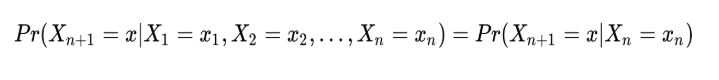

In [198]:
states=MF.columns

In [199]:
states

Index([''Round Midnight (1986)', ''Til There Was You (1997)',
       ''burbs, The (1989)', ''night Mother (1986)',
       '*batteries not included (1987)',
       '...All the Marbles (California Dolls, The) (1981)',
       '...And God Spoke (1993)', '...And Justice for All (1979)',
       '1-900 (06) (1994)', '10 (1979)',
       ...
       'Zoolander (2001)', 'Zoot Suit (1981)',
       'Zorba the Greek (Alexis Zorbas) (1964)', 'Zorro, the Gay Blade (1981)',
       'Zulu (1964)', 'Zus & Zo (2001)', 'eXistenZ (1999)', 'xXx (2002)',
       '¡Three Amigos! (1986)', 'À nous la liberté (Freedom for Us) (1931)'],
      dtype='object', name='title', length=8075)

In [200]:
transition_matrix=preds_df

In [201]:
transition_matrix = np.atleast_2d(transition_matrix)
states = states
index_dict = {states[index]: index for index in 
                           range(len(states))}
state_dict = {index: states[index] for index in
                           range(len(states))}

In [202]:
transition_matrix

array([[-0.01173362, -0.04078342,  0.20618808, ..., -0.05787899,
         0.1266037 ,  0.06573253],
       [ 0.0057974 ,  0.06476628,  0.02611344, ..., -0.0739291 ,
         0.02472141, -0.02680017],
       [ 0.02554202,  0.00979126,  0.13787154, ..., -0.20093719,
         0.3360195 , -0.03690627],
       ...,
       [-0.00742896, -0.05658112, -0.00124695, ...,  0.15292954,
        -0.10539649, -0.01011509],
       [-0.01495759, -0.06712312, -0.09030866, ...,  0.11932493,
         0.24012576, -0.02884447],
       [ 0.00151662, -0.0923985 ,  0.02432669, ...,  0.05952391,
         0.07110011, -0.02295111]])

In [203]:
index_dict

{"'Round Midnight (1986)": 0,
 "'Til There Was You (1997)": 1,
 "'burbs, The (1989)": 2,
 "'night Mother (1986)": 3,
 '*batteries not included (1987)': 4,
 '...All the Marbles (California Dolls, The) (1981)': 5,
 '...And God Spoke (1993)': 6,
 '...And Justice for All (1979)': 7,
 '1-900 (06) (1994)': 8,
 '10 (1979)': 9,
 '10 Rillington Place (1971)': 10,
 '10 Things I Hate About You (1999)': 11,
 '10 to Midnight (1983)': 12,
 '100 Girls (2000)': 13,
 '1000 Eyes of Dr. Mabuse, The (Die 1000 Augen des Dr. Mabuse) (1960)': 14,
 '101 Dalmatians (1996)': 15,
 '101 Dalmatians (One Hundred and One Dalmatians) (1961)': 16,
 '101 Reykjavik (101 Reykjavík) (2000)': 17,
 '102 Dalmatians (2000)': 18,
 '10th Victim, The (La decima vittima) (1965)': 19,
 '11\'09\\\\"01 - September 11 (2002)"': 20,
 '12 Angry Men (1957)': 21,
 '13 Ghosts (1960)': 22,
 '13 Going on 30 (2004)': 23,
 '13 Rue Madeleine (1947)': 24,
 '13th Warrior, The (1999)': 25,
 '1492: Conquest of Paradise (1992)': 26,
 '15 Minutes (2

In [204]:
state_dict

{0: "'Round Midnight (1986)",
 1: "'Til There Was You (1997)",
 2: "'burbs, The (1989)",
 3: "'night Mother (1986)",
 4: '*batteries not included (1987)',
 5: '...All the Marbles (California Dolls, The) (1981)',
 6: '...And God Spoke (1993)',
 7: '...And Justice for All (1979)',
 8: '1-900 (06) (1994)',
 9: '10 (1979)',
 10: '10 Rillington Place (1971)',
 11: '10 Things I Hate About You (1999)',
 12: '10 to Midnight (1983)',
 13: '100 Girls (2000)',
 14: '1000 Eyes of Dr. Mabuse, The (Die 1000 Augen des Dr. Mabuse) (1960)',
 15: '101 Dalmatians (1996)',
 16: '101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 17: '101 Reykjavik (101 Reykjavík) (2000)',
 18: '102 Dalmatians (2000)',
 19: '10th Victim, The (La decima vittima) (1965)',
 20: '11\'09\\\\"01 - September 11 (2002)"',
 21: '12 Angry Men (1957)',
 22: '13 Ghosts (1960)',
 23: '13 Going on 30 (2004)',
 24: '13 Rue Madeleine (1947)',
 25: '13th Warrior, The (1999)',
 26: '1492: Conquest of Paradise (1992)',
 27: '15 Minute

In [205]:
current_state="'Round Midnight (1986)"

In [206]:
p=transition_matrix[index_dict[current_state]]

In [207]:
p

array([-0.01173362, -0.04078342,  0.20618808, ..., -0.05787899,
        0.1266037 ,  0.06573253])

In [208]:
a = mc.MarkovChain().from_data(preds_df)

In [214]:
a.observed_matrix

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [219]:
a.observed_p_matrix

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [nan, nan, nan, ..., nan, nan, nan]])

In [223]:
aa=pd.DataFrame(a.observed_matrix, index=a.states, columns=a.states, dtype=float)

In [227]:
a.expected_matrix

array([[0.        , 0.00012385, 0.00012385, ..., 0.00012385, 0.00012385,
        0.00012385],
       [0.        , 0.00012385, 0.00012385, ..., 0.00012385, 0.00012385,
        0.00012385],
       [0.        , 0.00012385, 0.00012385, ..., 0.00012385, 0.00012385,
        0.00012385],
       ...,
       [0.        , 0.00012385, 0.00012385, ..., 0.00012385, 0.00012385,
        0.00012385],
       [0.        , 0.00012385, 0.00012385, ..., 0.00012385, 0.00012385,
        0.00012385],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [231]:
a.n_order_matrix(a.observed_p_matrix, order=2)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [235]:
a.chisquare(a.observed_matrix, a.expected_matrix, axis=None)

Power_divergenceResult(statistic=nan, pvalue=nan)

In [239]:
ids, states = a.simulate(10, start="Home Alone (1990)", seed=100)

In [240]:
ids

array([3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376])

In [241]:
states

array(['Home Alone (1990)', 'Home Alone 2: Lost in New York (1992)',
       'Home Alone 3 (1997)', 'Home Fries (1998)', 'Home Page (1999)',
       'Home Room (2002)', 'Home for the Holidays (1995)',
       'Home of Our Own, A (1993)', 'Home on the Range (2004)',
       'Homegrown (1998)'], dtype='<U134')

In [242]:
",".join(states)

'Home Alone (1990),Home Alone 2: Lost in New York (1992),Home Alone 3 (1997),Home Fries (1998),Home Page (1999),Home Room (2002),Home for the Holidays (1995),Home of Our Own, A (1993),Home on the Range (2004),Homegrown (1998)'

<p><b>Performance metric</b></p>
1. Mean Absolute Percentage Error
2. Root Mean Square Error

-> RMSE: Root Mean Square Error: RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.

-> MAPE: Mean Absolute Percentage Error: The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.

where At is the actual value and Ft is the forecast value.

The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

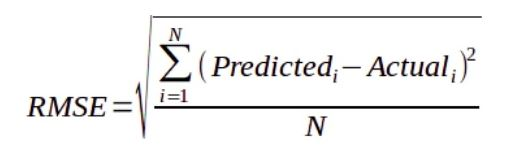

<h1>Surprise</h1>
To load a data set from the above pandas data frame, 
we will use the load_from_df() method, we will also need a Reader object, and 
the rating_scale parameter must be specified. The data frame must have three columns, corresponding to the user ids, 
the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [134]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[['userId', 'title','rating']], reader)

In [133]:
models_evaluation_train = dict()
models_evaluation_test = dict()
models_evaluation_train, models_evaluation_test

({}, {})

In [152]:
from sklearn.metrics import mean_squared_error

In [135]:
# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = data.build_full_trainset()

In [158]:
testset = list(zip(df["userId"].values, df["movieId"].values, df["rating"].values))

In [159]:
testset[:5]

[(1, 2, 3.5), (5, 2, 3.0), (13, 2, 3.0), (29, 2, 3.0), (34, 2, 3.0)]

In [332]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [333]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [169]:
def RMSE(real, predicted):
    """
    Calculate the root mean squared error between a matrix of real ratings and predicted ratings
    :param real: A matrix containing the real ratings (with 'NaN' for any missing elements)
    :param predicted: A matrix of predictions
    :return: The RMSE as a float
    """
    return np.sqrt(np.nanmean(np.square(real - predicted)))

In [171]:
RMSE(Matrix_normed,preds_df)

0.5247939503744018

In [335]:
def run_surprise(algo, trainset,testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    # https://surprise.readthedocs.io/en/stable/getting_started.html"
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    return train,test

In [336]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [337]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], 
                                                  columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

In [338]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)
train_result, test_result = run_surprise(algo, trainset,testset, "SVD")
model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7297093669161853
MAPE = 23.55769316736481
--------------------------------------------------
TEST DATA
RMSE = 0.9862218968330987
MAPE = 33.31743951713742
--------------------------------------------------
Time Taken = 0:01:58.641797


In [339]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}  
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
# best mae score
print(gs.best_score['mae'])
# combination of parameters that gave the best mae score
print(gs.best_params['mae'])

0.8501647493298675
{'n_factors': 50}
0.6532501331623201
{'n_factors': 50}


RMSE SCORE IS 0.8501647

### Cold Start Problem

#### Cold Start Problem with Users

In [253]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  
    #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
    #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

In [269]:
print("We are creating sparse data")
TrainUISparseData = sparse.csr_matrix((df.rating, (df.userId, df.movieId)))
print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))

We are creating sparse data
Creation done. Shape of sparse matrix = (5217, 26703)


In [280]:
### Average Rating Per User
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
print("Average rating of user 5216 = {}".format(AvgRatingUser[5216]))

Average rating of user 5216 = 3.8855421686746987


In [292]:
### Average Rating Per Movie
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))


Average rating of movie 4500 = 3.9722222222222223


In [278]:
total_users = len(np.unique(df["userId"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 5216
Number of Users in train data= 5216
Number of Users not present in train data = 0(0.0%)


#### Cold Start Problem with Movies

In [279]:
total_movies = len(np.unique(df["movieId"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 8075
Number of Movies in train data= 8075
Number of Movies not present in train data = 0(0.0%)
